In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import seaborn as sns
from sklearn.linear_model import Lasso

### Reading preprocessed data, done in g assignment

In [2]:
regression_df = pd.read_csv('./data/regression_cleaned.csv')

In [3]:
regression_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLw,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,60,65.000000,8125,6,5,1994,1995,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,80,75.000000,9750,5,5,1967,1967,0.0,400,480,...,0,0,0,1,0,0,0,0,1,0
2,160,70.077889,5105,7,5,2004,2004,0.0,239,0,...,0,0,0,1,0,0,0,0,1,0
3,20,50.000000,9405,5,9,1947,2008,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,50,78.000000,10496,6,6,1949,1950,320.0,196,0,...,0,0,0,1,0,0,0,0,1,0


#### Analyzing data through correlation matrix

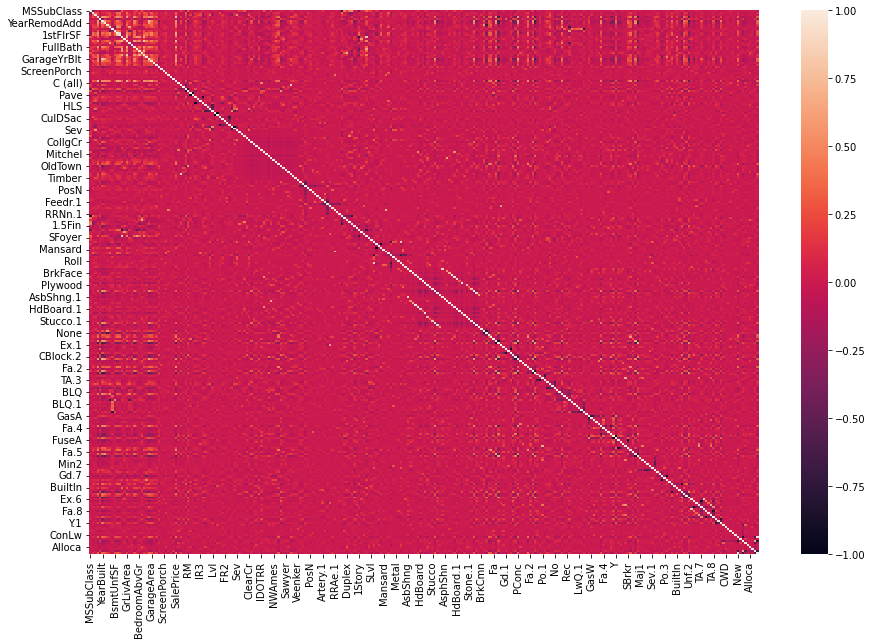

In [4]:
plt.figure(figsize=(15,10))
sns.heatmap(regression_df.corr())
plt.show()

### Preprocessing data - Splitting data into train, test

In [6]:
data_copy = regression_df.copy()

X = data_copy
y = data_copy.pop('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLw,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
1061,50,79.000000,9492,5,5,1941,1950,0.0,368,41,...,0,0,0,1,0,0,0,0,1,0
1142,60,85.000000,10574,8,5,2005,2006,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
793,60,70.000000,8400,8,6,2001,2001,0.0,643,0,...,0,0,0,1,0,0,0,0,1,0
724,20,80.000000,9920,5,5,1954,1954,110.0,354,290,...,0,0,0,1,0,0,0,0,1,0
374,120,70.077889,4500,6,5,1999,1999,425.0,883,0,...,0,0,0,1,0,0,0,0,1,0


In [8]:
def train_model(X_train, y_train, clf, **kwargs):
    return clf.fit(X=X_train, y=y_train, **kwargs)

### Feature importance with RandomForestRegressor

In [9]:
min_depth = 4
max_depth = 20
best_clf = None
best_predictions = None
best_max_depth = None

for depth in range(min_depth, max_depth):
    clf = RandomForestRegressor(n_estimators=100, max_depth=depth, criterion="squared_error", random_state=42)
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    
    if not best_clf:
        best_clf = clf
        best_predictions = predictions
        best_max_depth = depth
        continue
    
    if mean_squared_error(y_test, predictions) < mean_squared_error(y_test, best_predictions):
         best_clf = clf
         best_predictions = predictions
         best_max_depth = depth
   

In [10]:
importances = best_clf.feature_importances_
names = regression_df.columns.drop('SalePrice')
# std = np.std([tree.feature_importances_ for tree in best_clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=names)

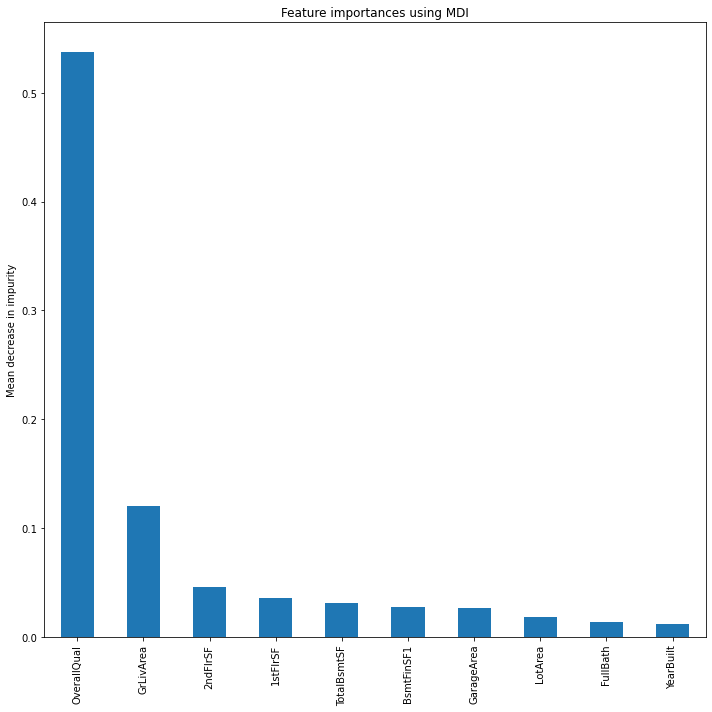

In [11]:
highest_importances = forest_importances.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,10))
highest_importances[:10].plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [15]:

features_to_remove = highest_importances.sort_values()[:5]

print(f"features to remove: {features_to_remove}")

features_to_remove = ['Ex.1', 'PosA.1', 'Po', 'ClyTile', 'Roll']

feature_importances = highest_importances.sort_values()[5:]
nr_of_feature_importences = len(feature_importances)

features to remove: Ex.1       0.000000e+00
PosA.1     0.000000e+00
Po         0.000000e+00
ClyTile    0.000000e+00
Roll       4.752818e-09
dtype: float64


### We took it a step deep further and tried to find optimal nr of features through grid search

In [20]:
# Grid search for finding optimal nr of features, using sorted list by feature importence
from tqdm import tqdm
fi = highest_importances[highest_importances > 0].keys()
no_fi = len(fi)

best_predictions = None
all_predictions = []
best_nr_of_features = None

for i in tqdm(range(1, no_fi - 1)):
    features = fi[:i]
    
    X_train_tmp = X_train[features]
    X_test_tmp = X_test[features]
    
    clf = RandomForestRegressor(n_estimators=100, max_depth=best_max_depth, criterion="squared_error", random_state=42)
    clf.fit(X_train_tmp, y_train)
   
    predictions = clf.predict(X_test_tmp)
    all_predictions.append(predictions)

    if  best_predictions is None:
        best_predictions = predictions
        best_nr_of_features = i
        continue
    
    if mean_squared_error(y_test, predictions) < mean_squared_error(y_test, best_predictions):
        best_predictions = predictions
        best_nr_of_features = i
        
        

100%|██████████| 267/267 [05:00<00:00,  1.13s/it]


In [21]:
print(f"Best total MSE: {sum(best_predictions)}")

Best total MSE: 50743953.377420664


In [22]:

print(f"Number of features in data: {len(names)}")
print(f"Best number of features {best_nr_of_features}")

Number of features in data: 273
Best number of features 227


In [23]:
### We then removed 5 features anyway as the assignment was

In [24]:
regression_rf_df = regression_df.drop(features_to_remove, axis=1)

In [25]:
len(regression_rf_df.columns) - 1

268

### feature selection (Lasso) with linear regression

In [26]:
lasso = Lasso()
alphas = np.linspace(0.01,500,100)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    

C:\Users\mimslade\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+11, tolerance: 7.248e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\mimslade\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.202e+10, tolerance: 7.248e+08
  model = cd_fast.enet_coordinate_descent(


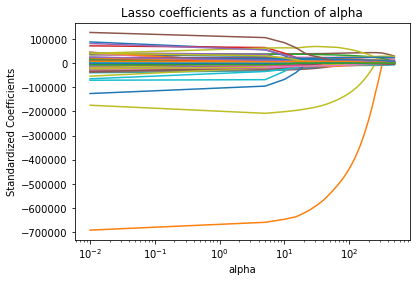

In [27]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')
plt.show()

In [28]:
lasso = Lasso()

search = GridSearchCV(lasso,
                      {'alpha':np.linspace(0.01,500,100)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [29]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..............alpha=0.01;, score=-2624416344.237 total time=   0.0s


C:\Users\mimslade\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+11, tolerance: 5.578e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\mimslade\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e+11, tolerance: 5.870e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............alpha=0.01;, score=-1407757591.156 total time=   0.0s
[CV 3/5] END ...............alpha=0.01;, score=-825455720.127 total time=   0.0s


C:\Users\mimslade\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e+11, tolerance: 5.749e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\mimslade\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.581e+10, tolerance: 5.904e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ...............alpha=0.01;, score=-705491424.448 total time=   0.0s
[CV 5/5] END ...............alpha=0.01;, score=-547718950.564 total time=   0.0s
[CV 1/5] END ..alpha=5.06040404040404;, score=-2562475644.907 total time=   0.0s


C:\Users\mimslade\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e+11, tolerance: 5.887e+08
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..alpha=5.06040404040404;, score=-1352395893.734 total time=   0.0s
[CV 3/5] END ...alpha=5.06040404040404;, score=-787539009.970 total time=   0.0s


C:\Users\mimslade\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.655e+10, tolerance: 5.904e+08
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ...alpha=5.06040404040404;, score=-689296887.266 total time=   0.0s
[CV 5/5] END ...alpha=5.06040404040404;, score=-504635546.356 total time=   0.0s
[CV 1/5] END .alpha=10.11080808080808;, score=-2547840314.576 total time=   0.0s
[CV 2/5] END .alpha=10.11080808080808;, score=-1313965974.471 total time=   0.0s
[CV 3/5] END ..alpha=10.11080808080808;, score=-758320432.292 total time=   0.0s
[CV 4/5] END ..alpha=10.11080808080808;, score=-664443617.431 total time=   0.0s
[CV 5/5] END ..alpha=10.11080808080808;, score=-480221552.851 total time=   0.0s
[CV 1/5] END alpha=15.161212121212122;, score=-2518488776.141 total time=   0.0s
[CV 2/5] END alpha=15.161212121212122;, score=-1285276990.543 total time=   0.0s
[CV 3/5] END .alpha=15.161212121212122;, score=-734323065.498 total time=   0.0s
[CV 4/5] END .alpha=15.161212121212122;, score=-645090127.076 total time=   0.0s
[CV 5/5] END .alpha=15.161212121212122;, score=-465198407.949 total time=   0.0s
[CV 1/5] END alpha=20.211616

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-02, 5.06040404e+00, 1.01108081e+01, 1.51612121e+01,
       2.02116162e+01, 2.52620202e+01, 3.03124242e+01, 3.53628283e+01,
       4.04132323e+01, 4.54636364e+01, 5.05140404e+01, 5.55644444e+01,
       6.06148485e+01, 6.56652525e+01, 7.07156566e+01, 7.57660606e+01,
       8.08164646e+01, 8.58668687e+01, 9.09172727e+01, 9....
       3.83840707e+02, 3.88891111e+02, 3.93941515e+02, 3.98991919e+02,
       4.04042323e+02, 4.09092727e+02, 4.14143131e+02, 4.19193535e+02,
       4.24243939e+02, 4.29294343e+02, 4.34344747e+02, 4.39395152e+02,
       4.44445556e+02, 4.49495960e+02, 4.54546364e+02, 4.59596768e+02,
       4.64647172e+02, 4.69697576e+02, 4.74747980e+02, 4.79798384e+02,
       4.84848788e+02, 4.89899192e+02, 4.94949596e+02, 5.00000000e+02])},
             scoring='neg_mean_squared_error', verbose=3)

In [30]:
best_alpha = search.best_params_['alpha']

In [31]:
importance = np.abs(search.best_estimator_.coef_)

In [33]:
best_features_lasso = np.array(X_train.columns)[importance > 0]
best_features_lasso

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'C (all)', 'RL', 'IR2',
       'Bnk', 'HLS', 'Low', 'Lvl', 'CulDSac', 'FR2', 'Mod', 'BrkSide',
       'CollgCr', 'Crawfor', 'Edwards', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'Somerst', 'StoneBr', 'Norm',
       'PosN.1', '2fmCon', 'Duplex', '1.5Fin', '1Story', '2Story',
       'ClyTile', 'WdShngl', 'BrkFace', 'HdBoard', 'MetalSd', 'VinylSd',
       'Wd Sdng', 'ImStucc.1', 'Plywood.1', 'VinylSd.1', 'None', 'Ex',
       'TA', 'Gd.1', 'BrkTil', 'PConc', 

In [34]:
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train, y_train)

Lasso(alpha=111.11888888888889)

In [35]:
len(X_train[best_features_lasso].columns)

102

### Inference With linear regression compared to transformation of target variables

In [36]:
print('R squared training set lasso', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set lasso', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set lasso 92.09
R squared test set lasso 87.91


In [37]:
X_train_log_1 = np.log1p(X_train)
X_test_log_1 = np.log1p(X_test)

In [38]:
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_log_1, y_train)
print('R squared training set', round(lasso_best.score(X_train_log_1, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test_log_1, y_test)*100, 2))

R squared training set 89.4
R squared test set 84.3


In [39]:
### Inference with random forest compared to transformation of target variables 

In [40]:
X_rf = regression_rf_df.copy()
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
print(len(X_rf.columns))
print(len(X_train_rf.columns))
len(X_test_rf.columns)

269
273


273

In [42]:
clf = RandomForestRegressor(n_estimators=100, max_depth=depth, criterion="squared_error", random_state=42)
clf.fit(X_train_rf, y_train_rf)

prediction = clf.predict(X_test_rf)
score = mean_squared_error(y_test, prediction)
deviations = abs(y_test - prediction)

print(f'Total mse: {score}\n')
print("Results through difference between mse of individual inferences:\n")
print(f'Worst result: {np.max(deviations)}')
print(f'Best result: {np.min(deviations)}')
print(f'Mean deviation: {np.mean(deviations)}')


score_1 = score.copy()

Total mse: 945247431.9505392

Results through difference between mse of individual inferences:

Worst result: 172707.78
Best result: 67.87166666667326
Mean deviation: 17993.905497462205


In [44]:
X_train_rf_log_1 = np.log1p(X_train_rf)
X_test_rf_log_1 = np.log1p(X_test_rf)

In [45]:
clf = RandomForestRegressor(n_estimators=100, max_depth=depth, criterion="squared_error", random_state=42)
clf.fit(X_train_rf_log_1, y_train_rf)

prediction = clf.predict(X_test_rf_log_1)
score = mean_squared_error(y_test, prediction)
deviations = abs(y_test - prediction)

print(f'Total mse: {score}\n')
print("Results through difference between mse of individual inferences:\n")
print(f'Worst result: {np.max(deviations)}')
print(f'Best result: {np.min(deviations)}')
print(f'Mean deviation: {np.mean(deviations)}')

score_2 = score.copy()

Total mse: 945899761.9615642

Results through difference between mse of individual inferences:

Worst result: 171955.73
Best result: 67.87166666667326
Mean deviation: 18008.9205719181


In [47]:
diviation_between_scores = score_1 - score_2

In [48]:
print(f"With transform you get a lower/better MSE. The difference is {diviation_between_scores}")

With transform you get a lower/better MSE. The difference is -652330.0110249519
